In [1]:
import pandas as pd
import pyterrier as pt
# read csvs without header, column names are qid, sep, uuid, score
import pyterrier as pt
if not pt.started():
    pt.init()
qrels = pt.io.read_qrels("../data/assessments/qrels.txt") # type: ignore
qcred = pt.io.read_qrels("../data/assessments/qcredibility.txt") # type: ignore
qread = pt.io.read_qrels("../data/assessments/qreadability.txt") # type: ignore


PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

def load_topics(path):
    with open(path) as f:
        root = ET.fromstring(f.read())
    topic_dict = {}
    for topic in root.findall("topic"):
        topic_id = topic.findtext("id")
        topic_query = topic.findtext("query")
        if topic_id and topic_query:
            topic_dict[topic_id] = topic_query.strip().lower()
    topics = pd.DataFrame(topic_dict.items(), columns=["qid", "query"]) 
    topics["query"] = topics["query"].str.replace(r'\W+', ' ', regex=True)
    return topics

In [3]:
queries = load_topics("./topics/topics.txt")

In [4]:
queries.head()

,qid,query
0,1,what are the most common chronic diseases what...
1,8,best apps daily activity exercise diabetes
2,22,my risk for developing type 2 diabetes
3,35,is a ketogenic keto diet suitable for people w...
4,45,can diabetes be cured


In [5]:
# print unique values of qcred column label
print(qcred.label.unique())

[2 1 0 3]


In [6]:
qrels.head()

,qid,docno,label
0,1,a6195d99-f7d7-43ec-907c-435cb7a62ee7,2
1,1,80fd9af1-c9b6-4d82-b62a-fe16d5b9d76f,1
2,1,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,2
3,1,22990a4b-6a9f-4e00-9e72-aef0fbee202b,0
4,1,fd6ddab2-e4d9-4151-9972-256f5be6eb21,1


In [4]:
all_passages = pd.read_csv("Webdoc/txt.tsv", sep="\t")

In [8]:
passages_with_qrels = pd.merge(all_passages, qrels, left_on="docid", right_on="docno")

In [10]:
passages_with_qrels.head()

,docid,text,qid,docno,label
0,44f906a1-f818-4d48-a3fb-1673ebdeff13,Skip to main content Patient Care and Safety D...,63,44f906a1-f818-4d48-a3fb-1673ebdeff13,2
1,44f906a1-f818-4d48-a3fb-1673ebdeff13,Skip to main content Patient Care and Safety D...,93,44f906a1-f818-4d48-a3fb-1673ebdeff13,2
2,44f906a1-f818-4d48-a3fb-1673ebdeff13,Skip to main content Patient Care and Safety D...,94,44f906a1-f818-4d48-a3fb-1673ebdeff13,1
3,334ed241-6337-41ce-884c-2755648e14ea,Skip to main content Patient Care and Safety D...,123,334ed241-6337-41ce-884c-2755648e14ea,1
4,391b9de2-26dc-4187-b7ea-461153352e12,Skip to main content Patient Care and Safety D...,93,391b9de2-26dc-4187-b7ea-461153352e12,1


In [11]:
# merge qrels, qcred, qread to one dataframe with columns qid, uuid, qrel, qcred, qread
qmerge = qrels.merge(qcred, on=["qid", "docno"], how="left")
qmerge = qmerge.merge(qread, on=["qid", "docno"], how="left")
qmerge = qmerge.rename(columns={"docno": "uuid", "label_x": "qrel", "label_y": "qcred", "label": "qread"})

In [12]:
# filter qmerge for uuids which are in all_passages
qmerge = qmerge[qmerge.uuid.isin(all_passages.docid)]

In [70]:
# get number of unique uuids
print(len(qmerge.uuid.unique()))
# get all duplicate uuids and print them, incuding the number of duplicates and the values in the columns as list
duplicates = qmerge[qmerge.uuid.duplicated(keep=False)].groupby("uuid").agg({"uuid": "count", "qrel": list, "qcred": list, "qread": list, "qid": list}).rename(columns={"uuid": "count"}).sort_values("count", ascending=False)

# visualize duplicates
duplicates.head()
print(len(duplicates))

print("total number of uuids ", len(qmerge))

6692
875
total number of uuids in qrels:  8902


In [73]:
duplicates.head()

,count,qrel,qcred,qread,qid
uuid,,,,,
ec97f55f-12fd-4b1b-ba89-32e5ec77f28f,18,"[2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2, 1, ...","[2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[54, 55, 57, 58, 59, 63, 68, 72, 77, 79, 81, 8..."
fc1fd012-c7d3-4ed2-ae3b-ed795426759c,17,"[2, 2, 2, 1, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, ...","[2, 2, 2, 1, 1, 2, 1, 3, 1, 2, 1, 1, 3, 2, 1, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, ...","[54, 55, 57, 58, 63, 68, 72, 77, 79, 81, 83, 8..."
401363ff-141a-4cc9-8b47-484a277e102f,16,"[2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 1, 2, 0]","[2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2]","[2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0]","[54, 55, 57, 58, 59, 63, 68, 77, 79, 81, 83, 8..."
d357d189-6cfd-41eb-85ed-a89de43886a3,15,"[2, 2, 2, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]","[2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2]","[54, 55, 57, 58, 59, 68, 72, 77, 81, 83, 85, 8..."
feec527f-e1da-49d7-8b1b-088e94ec18ac,14,"[1, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 1, 0]","[2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 0, 0]","[2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0]","[54, 55, 57, 58, 59, 63, 68, 79, 81, 83, 85, 9..."


In [72]:
# plot first duplicate uuid and compare the values of qrel, qcred, qread using a seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

dup = duplicates.iloc[0]
# expand the lists in the columns to columns
dup = dup.apply(pd.Series).T
dup.to_clipboard()

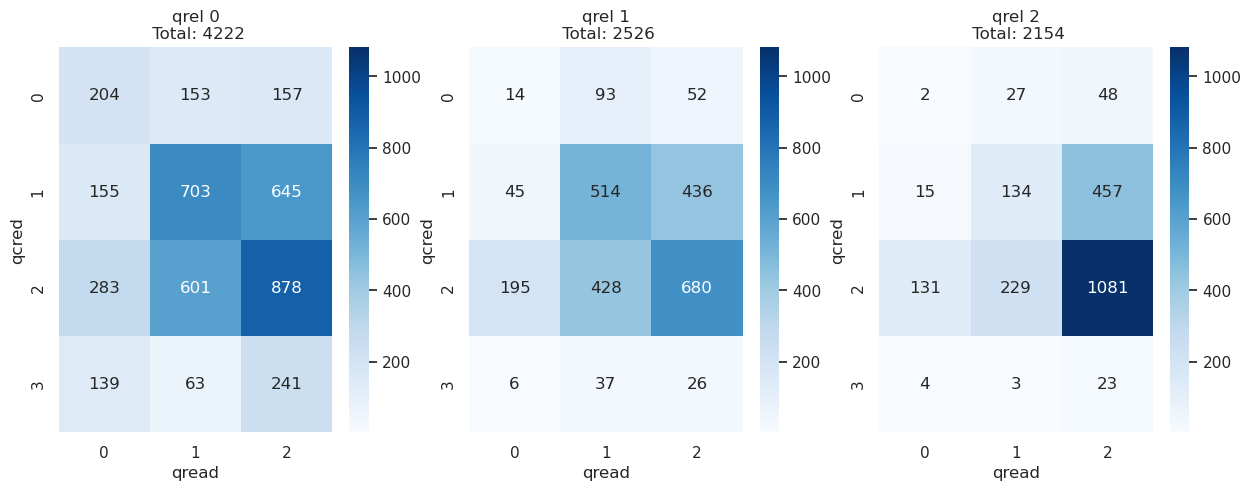

In [53]:
# generate separate heatmap for qrel 0,1 and 2, showing qcred and qread on the x and y axis. Usa a nice color scheme and annotate the cells with the number of passages in each cell.

import seaborn as sns
import matplotlib.pyplot as plt

qmerge["qrel"] = qmerge["qrel"].astype(int)
qmerge["qcred"] = qmerge["qcred"].astype(int)
qmerge["qread"] = qmerge["qread"].astype(int)

# generate 3 heatmaps next to each other
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# heatmap for qrels. colormap should have same intensity for all qrels
cmap = sns.color_palette("Blues", as_cmap=True)
vmin = qmerge.groupby(["qrel", "qcred", "qread"]).size().min()
vmax = qmerge.groupby(["qrel", "qcred", "qread"]).size().max()
for rel in [0,1,2]:
    qrel = qmerge[qmerge.qrel == rel]
    sns.heatmap(qrel.groupby(["qcred", "qread"]).size().unstack(), annot=True, fmt="d", ax=axes[rel], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[rel].set_title(f"qrel {rel}" + "\n Total: " + str(len(qrel)))


In [74]:
def get_text_from_uuid(uuid):
    return all_passages[all_passages.docid == uuid].text.values[0]

def get_query_from_qid(qid):
    return queries[queries.qid == qid]['query'].values[0]

get_text_from_uuid("ec97f55f-12fd-4b1b-ba89-32e5ec77f28f")

'Topics A-Z Slideshows Images Quizzes Supplements Medications Privacy Policy About Us Contact Us Terms of Use Advertising Policy ©2018 WebMD, Inc. All rights reserved. eMedicineHealth does not provide medical advice, diagnosis or treatment. See Additional Information. home brain & nervous system center brain & nervous system a-z list slideshows a-z list What Is Multiple Sclerosis? MS Symptoms, Causes, Diagnosis Reviewed By: Charles Patrick Davis, MD, PhD Reviewed on 11/9/2020 What Is MS? Multiple sclerosis (MS) is an autoimmune disease in which the body\'s immune system attacks its own central nervous system (the brain and spinal cord). In MS, the immune system attacks and damages or destroys myelin, a substance that surrounds and insulates the nerves. The myelin destruction causes a distortion or interruption in nerve impulses traveling to and from the brain. This can result in a wide variety of symptoms. Who Can Get Multiple Sclerosis? Multiple sclerosis is estimated to affect 2.8 mi

In [77]:
for qid in [72, 77, 94, 83, 81, 92, 95, 59, 79, 85, 86, 93, 54, 55, 57, 58, 63, 68]:
    print(get_query_from_qid(str(qid)))

is the covid 19 vaccine safe for people taking multiple sclerosis drugs 
how do menopause symptoms relate to multiple sclerosis symptoms 
when will i start to feel better with multiple sclerosis 
why get episode diagnosed by a doctor as a relapse of multiple sclerosis 
can i work and study full time with multiple sclerosis 
causes of fatigue in ms
reading problems in ms
long term effects likelihood multiple sclerosis
can i pass multiple sclerosis to other family members 
relapsing remitting multiple sclerosis
secondary progressive multiple sclerosis
does multiple sclerosis relate to sleeping problems and forgetfulness in older people 
what does multiple sclerosis diagnosis include what does it change 
how to manage multiple sclerosis 
multiple sclerosis stages phases
risk to develop multiple sclerosis
will multiple sclerosis affect my career 
list of multiple sclerosis symptoms


In [ ]:
# new df with cols qid, qrel_0, qrel_1, qrel_2, qcred_0, qcred_1, qcred_2, qread_0, qread_1, qread_2
# uuid is dropped, qrel_0 contains the number of uuids with qrel=0 for each qid
qagg = qmerge.groupby(["qid"]).agg({"qrel": [lambda x: (x==0).sum(), lambda x: (x==1).sum(), lambda x: (x==2).sum()],
                                        "qcred": [lambda x: (x==0).sum(), lambda x: (x==1).sum(), lambda x: (x==2).sum(), lambda x: (x==3).sum()],
                                        "qread": [lambda x: (x==0).sum(), lambda x: (x==1).sum(), lambda x: (x==2).sum()],
                                        "uuid": "count"})
qagg.columns = ["qrel_0", "qrel_1", "qrel_2", "qcred_0", "qcred_1", "qcred_2", "qcred_3", "qread_0", "qread_1", "qread_2", "uuid_count"]
qagg = qagg.reset_index()
# order dataframe by qid, qid as integer
qagg = qagg.sort_values(by=["qid"], key=lambda x: x.astype(int))

,qid,qrel_0,qrel_1,qrel_2,qcred_0,qcred_1,qcred_2,qcred_3,qread_0,qread_1,qread_2,uuid_count
0,1,71,86,87,59,83,102,0,8,85,151,244
38,8,191,22,22,18,178,39,0,2,69,164,235
21,22,86,93,70,38,56,147,8,30,128,91,249
22,35,133,10,11,23,122,2,7,13,46,95,154
23,45,36,36,53,44,31,39,11,64,47,14,125
24,51,53,83,50,39,109,26,12,48,113,25,186
25,52,95,51,43,3,44,133,9,35,101,53,189
26,53,149,17,13,1,114,49,15,30,137,12,179
27,54,151,53,41,1,42,193,9,7,74,164,245
28,55,130,73,42,0,86,154,5,3,18,224,245


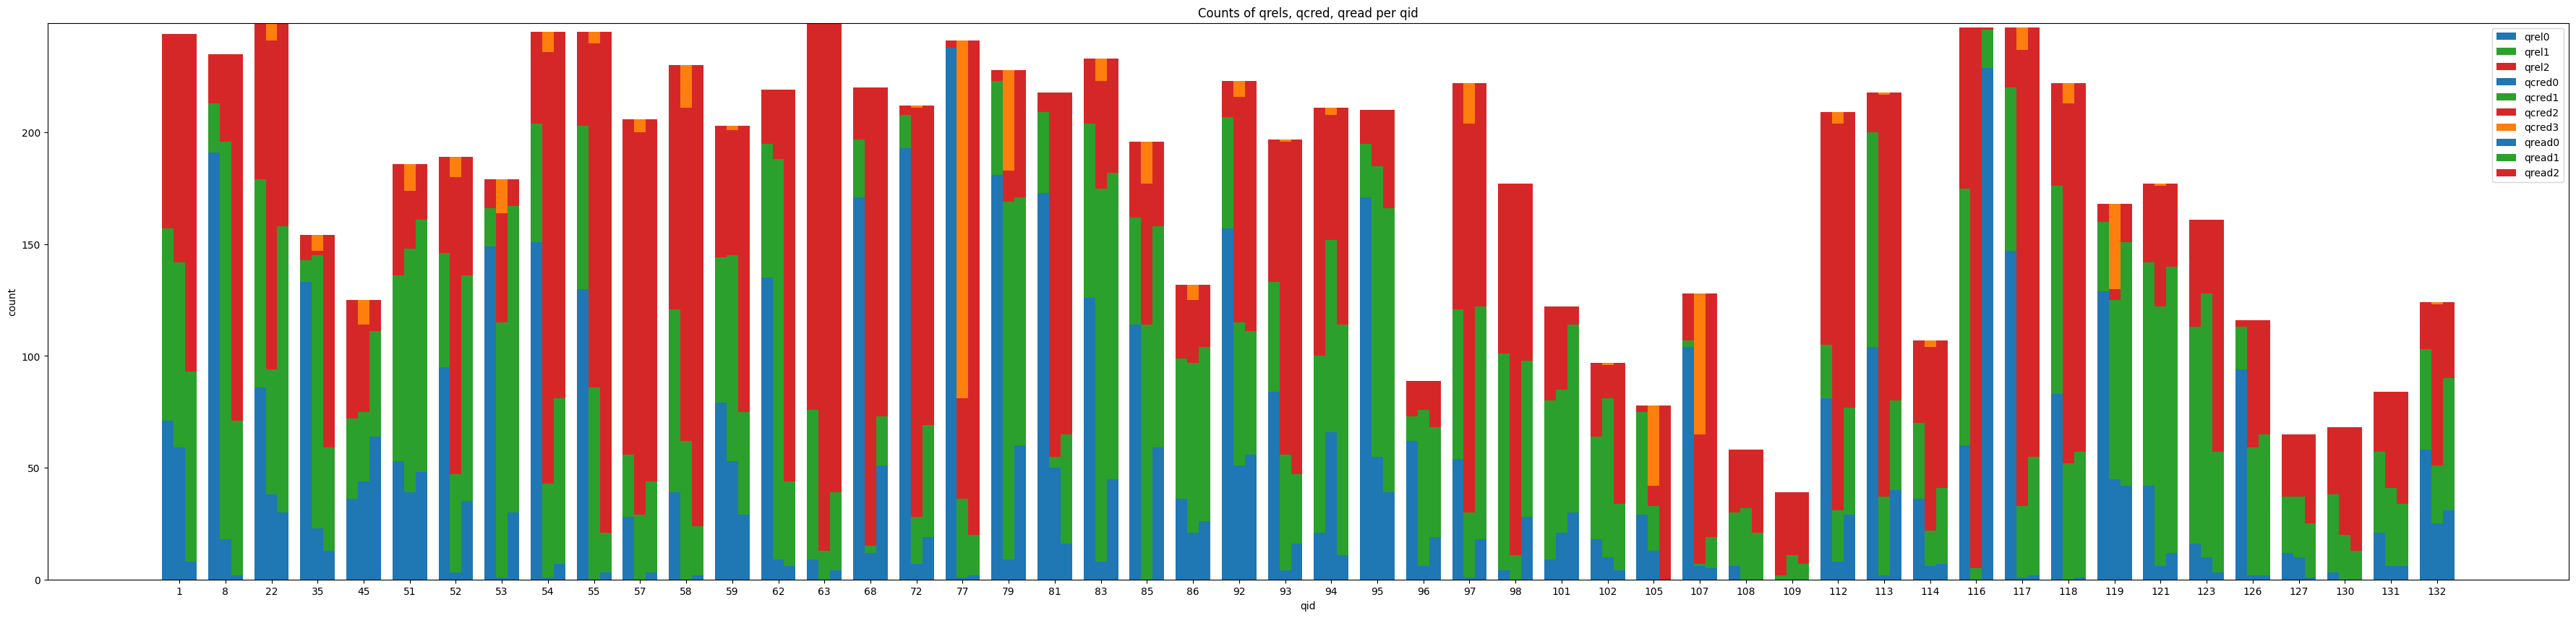

In [ ]:
# visualize the table as a bar chart. qrels, qcred, qread are plotted in separate bars, to in total 3 bars per qid.
# The different values (qrel_0, qrel_1, qrel2) of qrels, qcred, qread are stacked on top of each other.
import numpy as np
import matplotlib.pyplot as plt

# increase figure size
plt.rcParams['figure.figsize'] = [45, 10]

fig, ax = plt.subplots()
# set width of bar
width = 0.25

# 4 colors blue green red yellow
colors = ["#1f77b4", "#2ca02c", "#d62728", "#ff7f0e"]

bottom = np.zeros(50)

weight_counts_qrels = {
    "qrel0": qagg.qrel_0,
    "qrel1": qagg.qrel_1,
    "qrel2": qagg.qrel_2
}

weight_counts_qcred = {
    "qcred0": qagg.qcred_0,
    "qcred1": qagg.qcred_1,
    "qcred2": qagg.qcred_2,
    "qcred3": qagg.qcred_3
}
weight_counts_qread = {
    "qread0": qagg.qread_0,
    "qread1": qagg.qread_1,
    "qread2": qagg.qread_2
}

all_weight_counts = [weight_counts_qrels, weight_counts_qcred, weight_counts_qread]

x = np.arange(50)
for idx, all_weight in enumerate(all_weight_counts):
    bottom = np.zeros(50)
    color_index = 0
    for boolean, weight_count in all_weight.items():
        p = ax.bar(x + idx*0.25, weight_count, width, label=boolean, bottom=bottom, color=colors[color_index])
        bottom += weight_count
        color_index += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

plt.xlabel('qid')
plt.ylabel('count')
plt.title('Counts of qrels, qcred, qread per qid')
plt.xticks(x + width, qagg.qid)
# Create legend & Show graphic
plt.legend()
plt.show()
